# IBM HR Analytics: Çalışan Devamsızlık Tahmini ve Performans Analizi
# Bu notebook IBM HR Analytics veri seti kullanılarak çalışan devamsızlık tahmini ve performans analizi yapmak için oluşturulmuştur.

In [1]:
# Gerekli kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(font_scale=1.2)


In [6]:
# Veri setinin yüklenmesi
print("Veri seti yükleniyor...")
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Çalışan  Devamsızlık Performans Analizi/WA_Fn-UseC_-HR-Employee-Attrition.csv')

Veri seti yükleniyor...


In [7]:
# Veri seti hakkında genel bilgi
df = pd.read_csv(path)
print("\nVeri seti hakkında genel bilgi:")
print(f"Satır sayısı: {df.shape[0]}, Sütun sayısı: {df.shape[1]}")
print("\nİlk 5 satır:")
print(df.head())


Veri seti hakkında genel bilgi:
Satır sayısı: 1470, Sütun sayısı: 35

İlk 5 satır:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1           

In [8]:
# Veri setindeki değişkenlerin türleri ve eksik değer kontrolü
print("\nDeğişken türleri ve eksik değer kontrolü:")
print(df.info())
print("\nEksik değer sayısı:")
print(df.isnull().sum().sum())


Değişken türleri ve eksik değer kontrolü:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-

In [9]:
# Hedef değişkenin dağılımı
print("\nHedef değişken (Attrition) dağılımı:")
attrition_counts = df['Attrition'].value_counts()
print(attrition_counts)
print(f"Ayrılma oranı: {attrition_counts['Yes'] / len(df):.2%}")


Hedef değişken (Attrition) dağılımı:
Attrition
No     1233
Yes     237
Name: count, dtype: int64
Ayrılma oranı: 16.12%


In [10]:
# Sayısal değişkenlerin istatistikleri
print("\nSayısal değişkenlerin istatistikleri:")
print(df.describe())


Sayısal değişkenlerin istatistikleri:
               Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.7299

In [11]:
# Veri Görselleştirme ve Keşifsel Veri Analizi (EDA)
print("\nKeşifsel Veri Analizi yapılıyor...")

# Gereksiz sütunları kaldırma (Employee Count, Over18, StandardHours gibi sabit değerli olanlar)
df = df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1)

# Kategorik değişkenleri sayısala çevirme
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})



Keşifsel Veri Analizi yapılıyor...


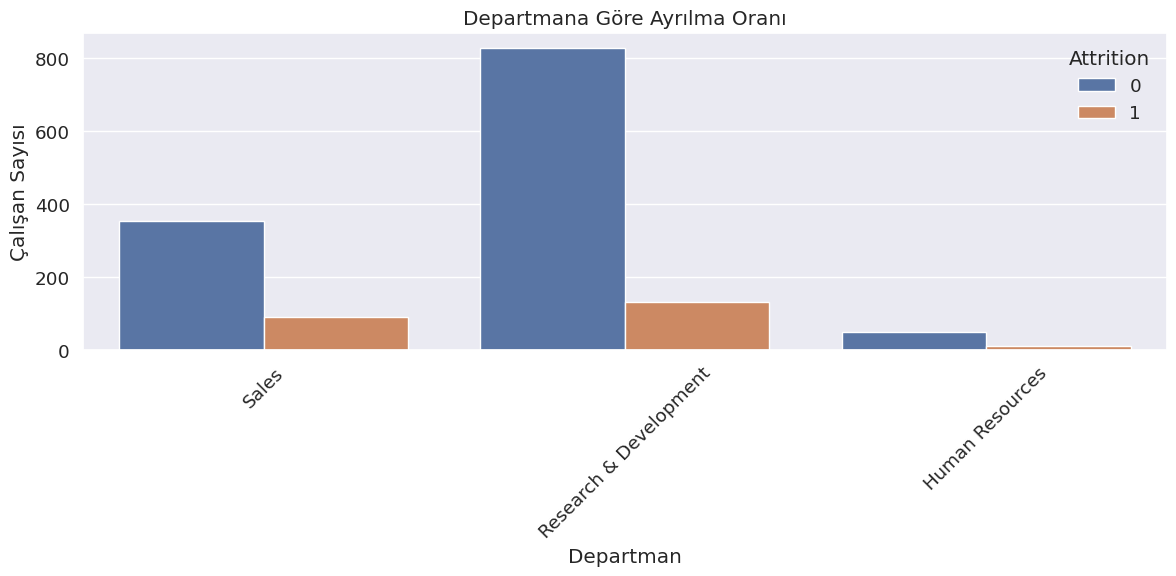

In [12]:
# Departmana göre ayrılma oranı
plt.figure(figsize=(12, 6))
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Departmana Göre Ayrılma Oranı')
plt.xlabel('Departman')
plt.ylabel('Çalışan Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

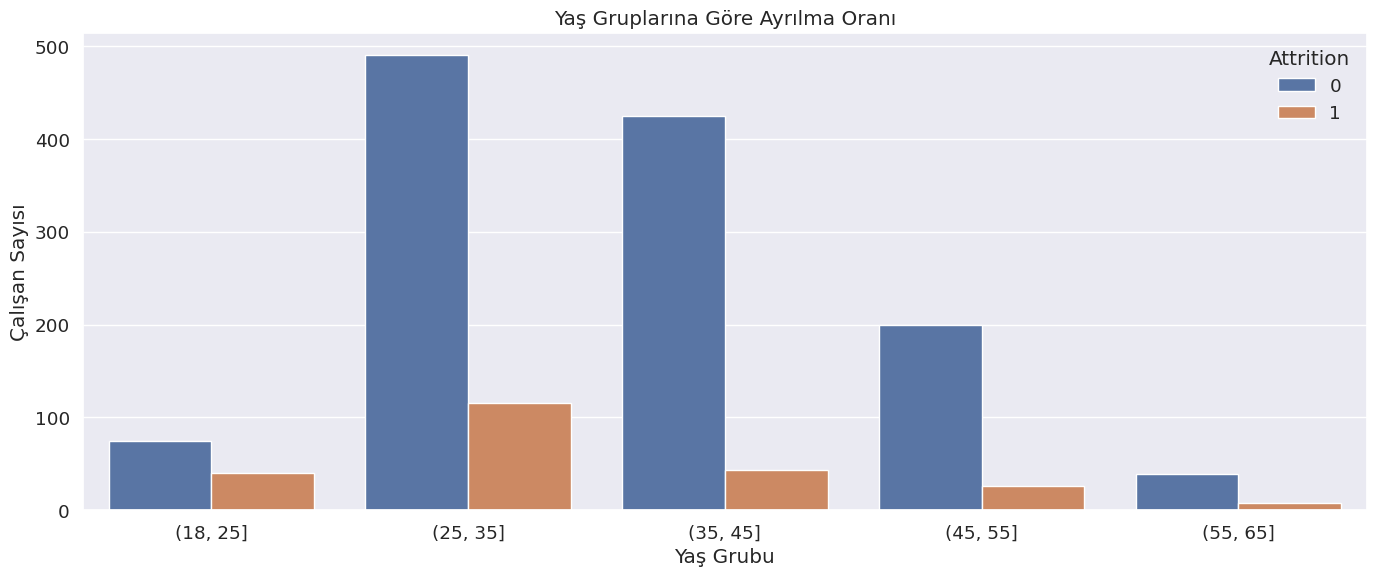

In [13]:
# Yaş gruplarına göre ayrılma oranı
plt.figure(figsize=(14, 6))
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65])
sns.countplot(x='AgeGroup', hue='Attrition', data=df)
plt.title('Yaş Gruplarına Göre Ayrılma Oranı')
plt.xlabel('Yaş Grubu')
plt.ylabel('Çalışan Sayısı')
plt.tight_layout()
plt.show()


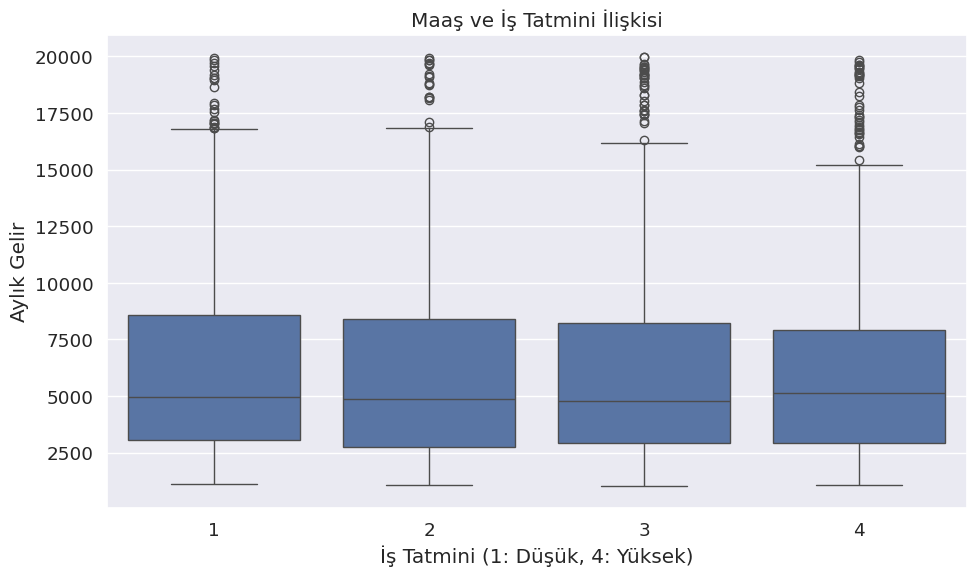

In [14]:
# Maaş ve iş tatmini ilişkisi
plt.figure(figsize=(10, 6))
sns.boxplot(x='JobSatisfaction', y='MonthlyIncome', data=df)
plt.title('Maaş ve İş Tatmini İlişkisi')
plt.xlabel('İş Tatmini (1: Düşük, 4: Yüksek)')
plt.ylabel('Aylık Gelir')
plt.tight_layout()
plt.show()


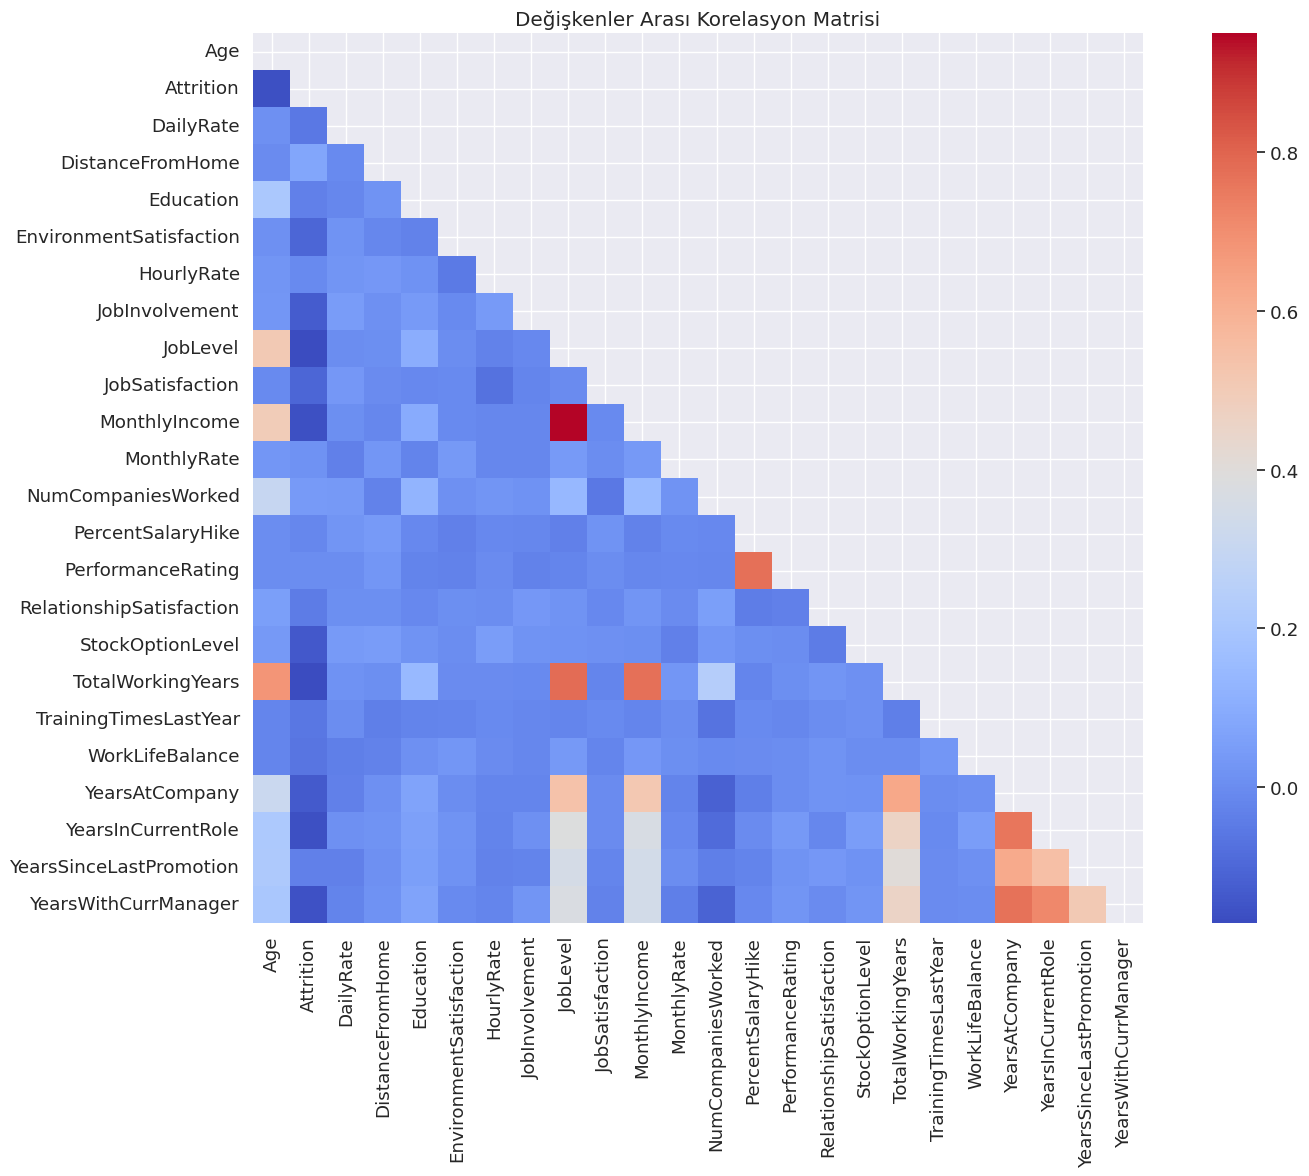

In [15]:
# Korelasyon analizi
plt.figure(figsize=(16, 12))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt='.2f', square=True)
plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.tight_layout()
plt.show()


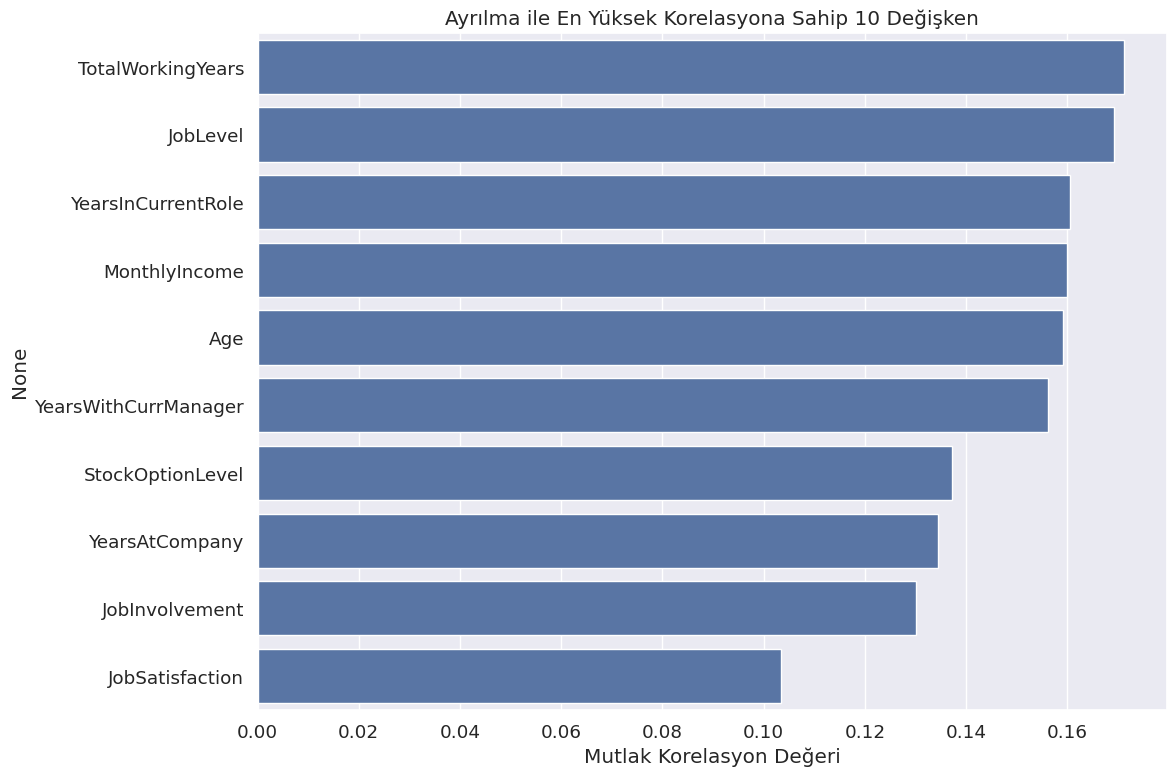

In [16]:
# Ayrılma ile en yüksek korelasyona sahip 10 değişken
plt.figure(figsize=(12, 8))
attrition_corr = abs(corr['Attrition']).sort_values(ascending=False)
top_corr_features = attrition_corr[1:11]  # Attrition'ın kendisini çıkarıyoruz
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title('Ayrılma ile En Yüksek Korelasyona Sahip 10 Değişken')
plt.xlabel('Mutlak Korelasyon Değeri')
plt.tight_layout()
plt.show()


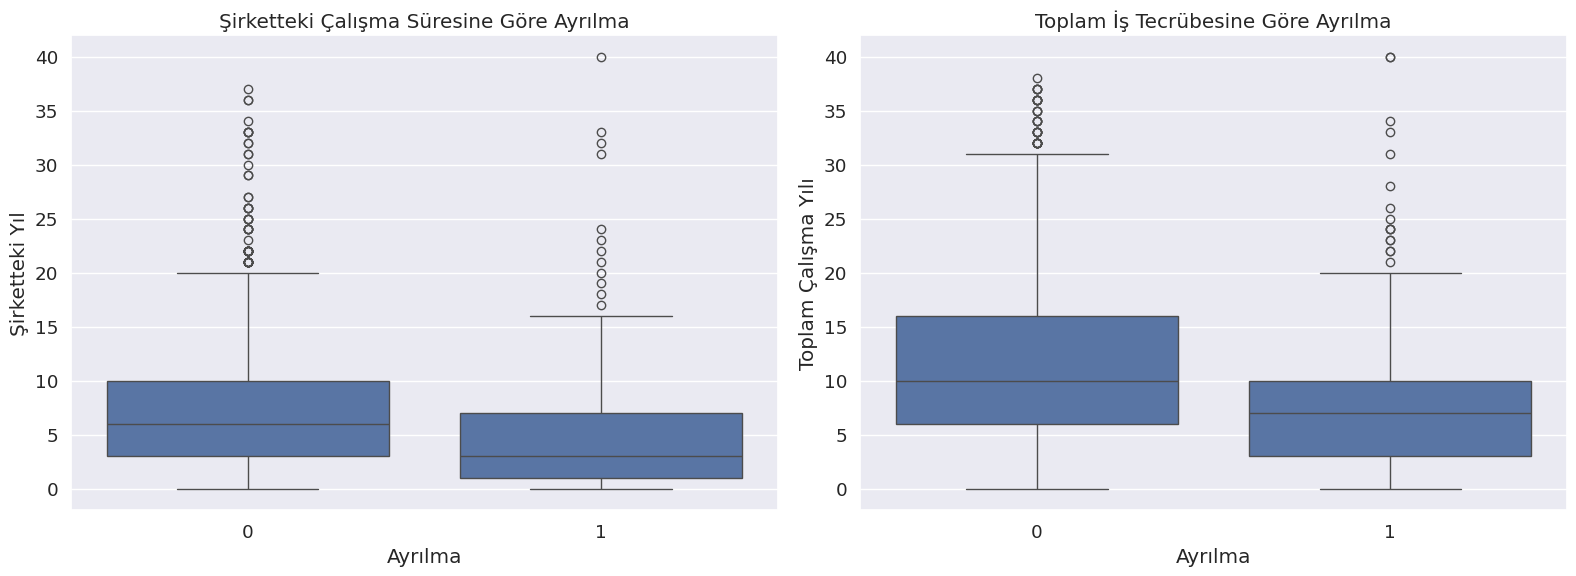

In [17]:
# İş tecrübesi ve çalışma süresi analizi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='Attrition', y='YearsAtCompany', data=df, ax=axes[0])
axes[0].set_title('Şirketteki Çalışma Süresine Göre Ayrılma')
axes[0].set_xlabel('Ayrılma')
axes[0].set_ylabel('Şirketteki Yıl')

sns.boxplot(x='Attrition', y='TotalWorkingYears', data=df, ax=axes[1])
axes[1].set_title('Toplam İş Tecrübesine Göre Ayrılma')
axes[1].set_xlabel('Ayrılma')
axes[1].set_ylabel('Toplam Çalışma Yılı')
plt.tight_layout()
plt.show()


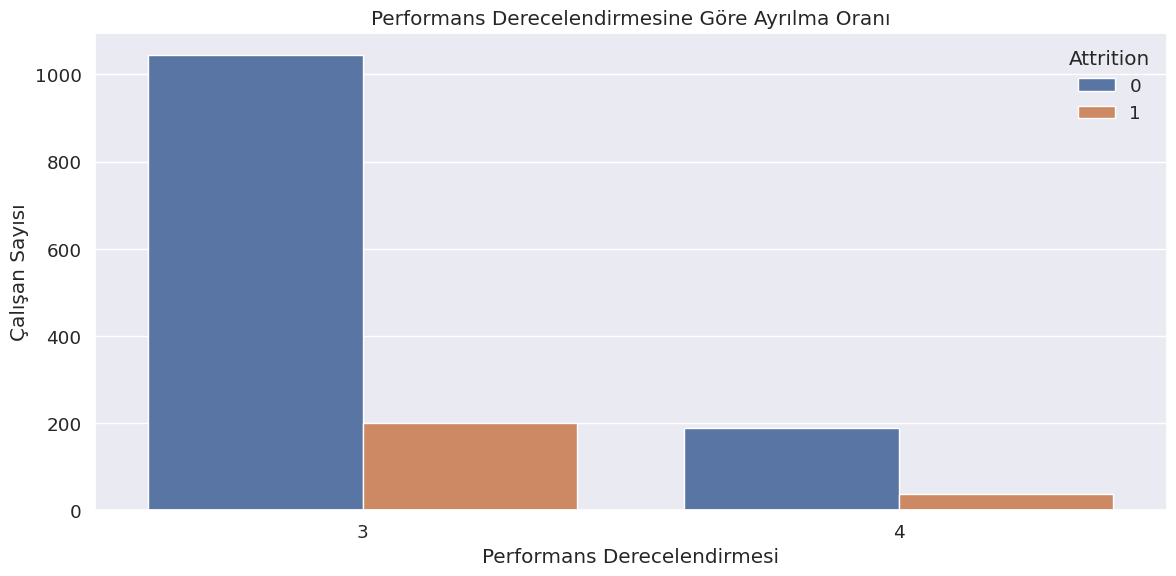

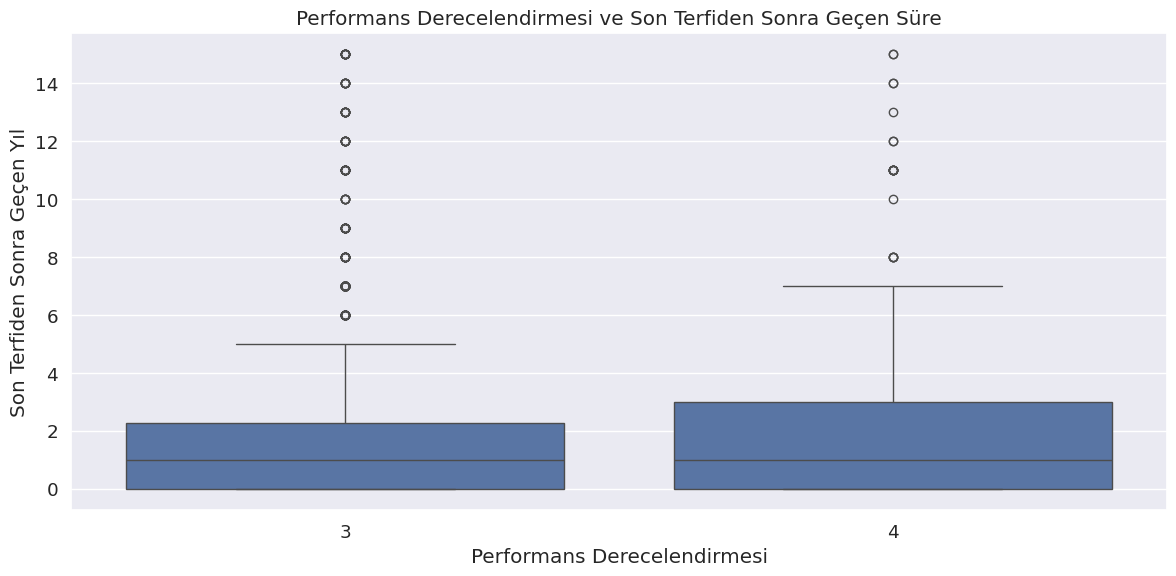

In [18]:
# Performans derecelendirmesi ve terfi analizi
plt.figure(figsize=(12, 6))
sns.countplot(x='PerformanceRating', hue='Attrition', data=df)
plt.title('Performans Derecelendirmesine Göre Ayrılma Oranı')
plt.xlabel('Performans Derecelendirmesi')
plt.ylabel('Çalışan Sayısı')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='PerformanceRating', y='YearsSinceLastPromotion', data=df)
plt.title('Performans Derecelendirmesi ve Son Terfiden Sonra Geçen Süre')
plt.xlabel('Performans Derecelendirmesi')
plt.ylabel('Son Terfiden Sonra Geçen Yıl')
plt.tight_layout()
plt.show()

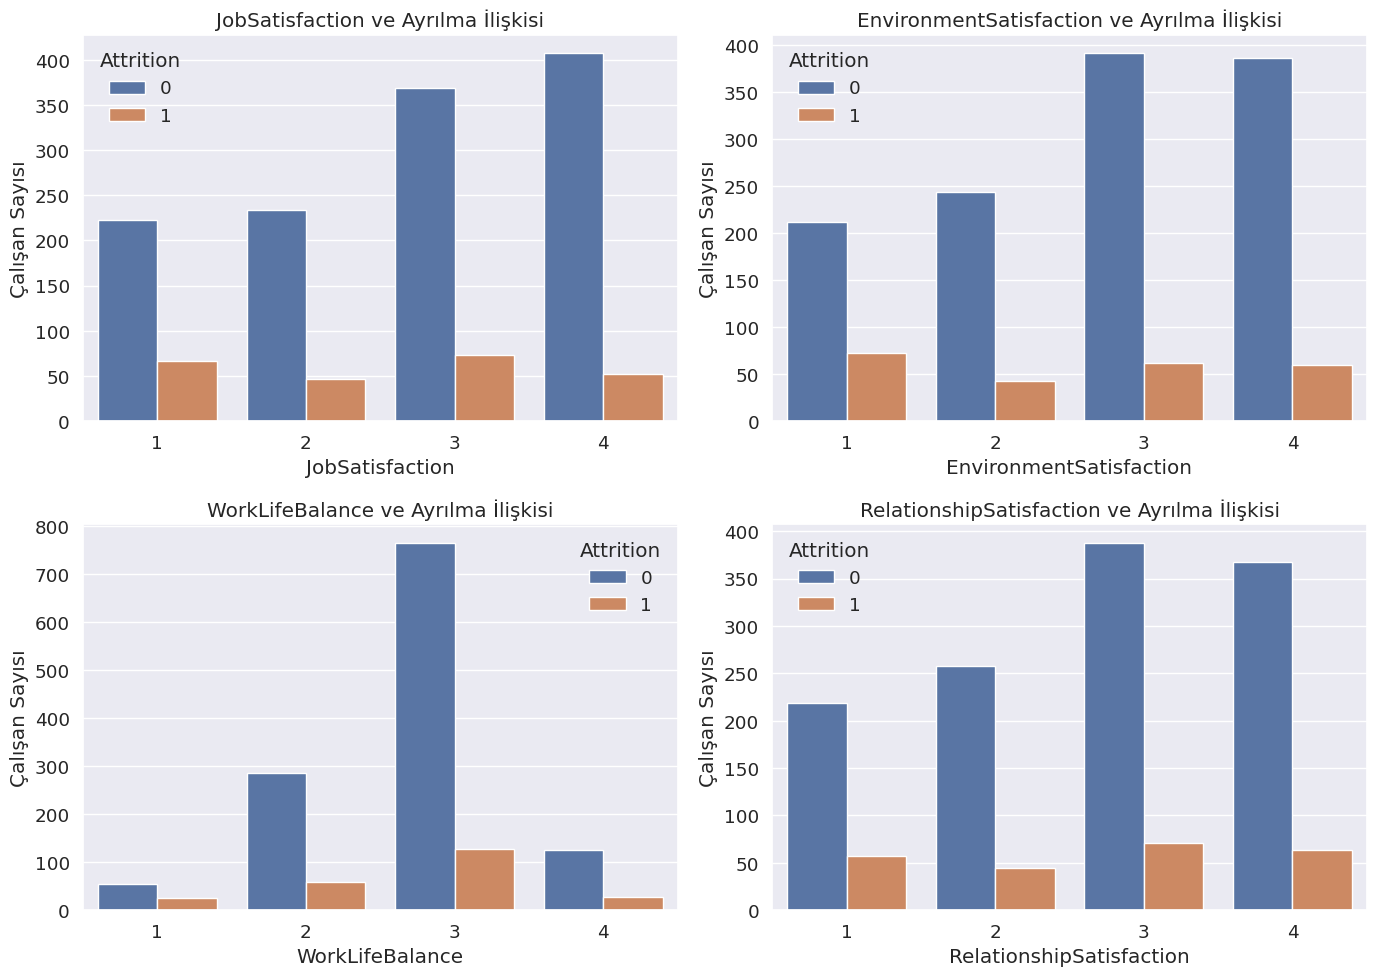

In [19]:
# İşten memnuniyet faktörleri analizi
satisfaction_features = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'RelationshipSatisfaction']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(satisfaction_features):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=feature, hue='Attrition', data=df)
    plt.title(f'{feature} ve Ayrılma İlişkisi')
    plt.xlabel(feature)
    plt.ylabel('Çalışan Sayısı')
plt.tight_layout()
plt.show()


In [20]:
# Veri Ön İşleme
print("\nVeri ön işleme yapılıyor...")

# Hedef değişken ve özellikler
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Kategorik ve sayısal değişkenleri ayırma
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# AgeGroup sütununu kaldıralım (analiz için oluşturduk)
if 'AgeGroup' in X.columns:
    X = X.drop('AgeGroup', axis=1)
    if 'AgeGroup' in numerical_features:
        numerical_features = numerical_features.drop('AgeGroup')
    if 'AgeGroup' in categorical_features:
        categorical_features = categorical_features.drop('AgeGroup')

# Veri önişleme pipeline'ı
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Veri ön işleme yapılıyor...


In [21]:
# Veri setini eğitim ve test olarak bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dengesiz veri seti için SMOTE uygulama
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

print(f"Orijinal eğitim seti şekli: {X_train.shape}")
print(f"SMOTE sonrası eğitim seti şekli: {X_train_resampled.shape}")
print(f"Orijinal ayrılma dağılımı: {pd.Series(y_train).value_counts()}")
print(f"SMOTE sonrası ayrılma dağılımı: {pd.Series(y_train_resampled).value_counts()}")


Orijinal eğitim seti şekli: (1176, 30)
SMOTE sonrası eğitim seti şekli: (1972, 51)
Orijinal ayrılma dağılımı: Attrition
0    986
1    190
Name: count, dtype: int64
SMOTE sonrası ayrılma dağılımı: Attrition
0    986
1    986
Name: count, dtype: int64


In [22]:
# Model Oluşturma ve Eğitim
print("\nModeller oluşturuluyor ve eğitiliyor...")

# Farklı modeller oluşturma
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Model değerlendirme sonuçları
results = {}



Modeller oluşturuluyor ve eğitiliyor...


In [23]:
# SMOTE ile dengelenmiş veri kullanarak modelleri eğit ve değerlendir
for name, model in models.items():
    print(f"\n{name} modeli eğitiliyor...")

    # Modeli eğit
    model.fit(X_train_resampled, y_train_resampled)

    # Test seti üzerinde tahmin yap
    X_test_preprocessed = preprocessor.transform(X_test)
    y_pred = model.predict(X_test_preprocessed)
    y_proba = model.predict_proba(X_test_preprocessed)[:, 1]

    # Performans metriklerini hesapla
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ROC eğrisi hesaplama
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Sonuçları kaydet
    results[name] = {
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

    print(f"{name} Doğruluk: {accuracy:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print("Sınıflandırma Raporu:")
    print(report)

# En iyi modeli seç
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"\nEn iyi model: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})")



Logistic Regression modeli eğitiliyor...
Logistic Regression Doğruluk: 0.7653
AUC: 0.7958
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       247
           1       0.36      0.57      0.44        47

    accuracy                           0.77       294
   macro avg       0.63      0.69      0.65       294
weighted avg       0.82      0.77      0.79       294


Random Forest modeli eğitiliyor...
Random Forest Doğruluk: 0.8435
AUC: 0.7981
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.52      0.26      0.34        47

    accuracy                           0.84       294
   macro avg       0.70      0.61      0.63       294
weighted avg       0.82      0.84      0.82       294


Gradient Boosting modeli eğitiliyor...
Gradient Boosting Doğruluk: 0.8571
AUC: 0.7941
Sınıflandırma Raporu:
              precision

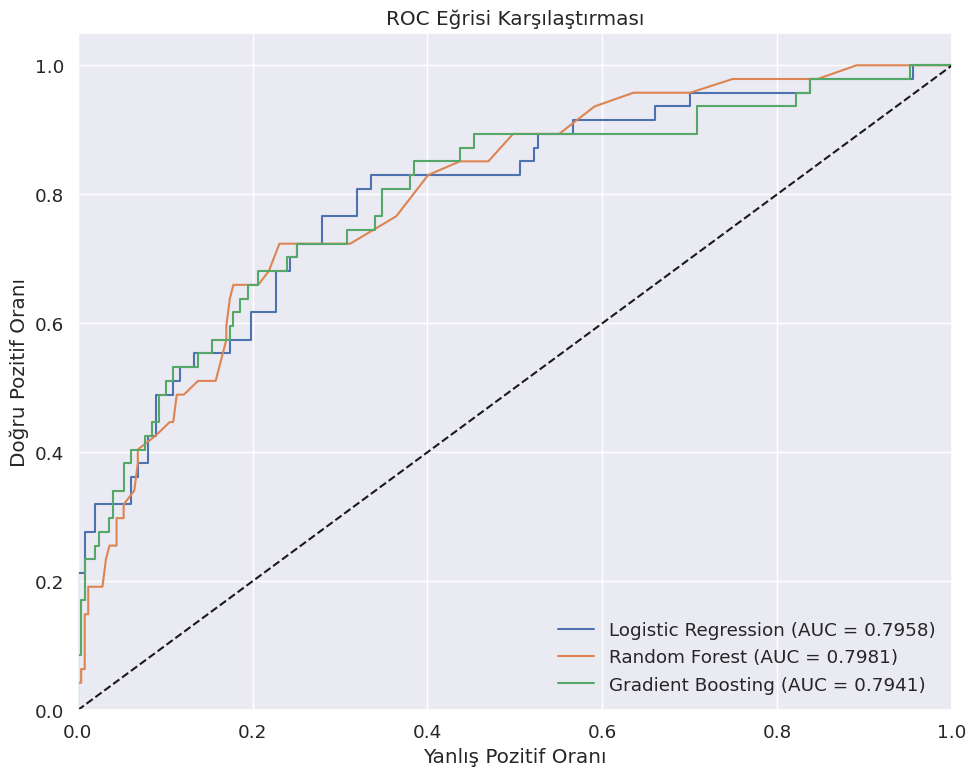

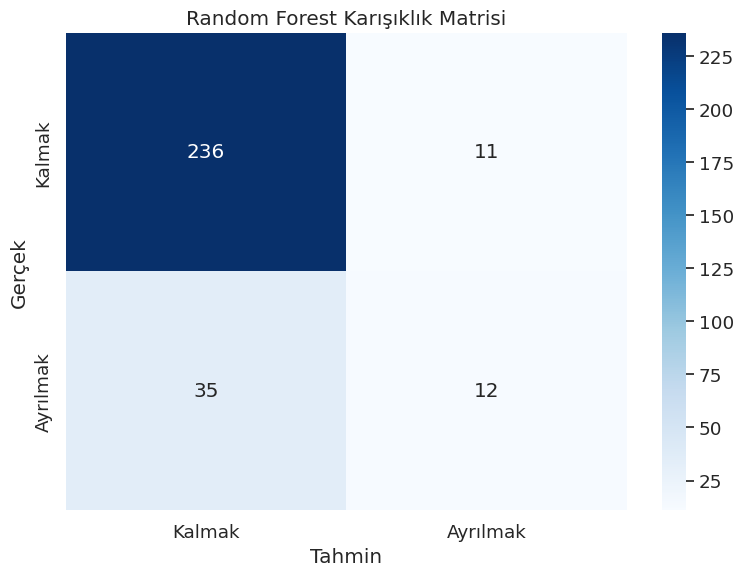

In [24]:
# Sonuçları görselleştir
# ROC eğrileri
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('ROC Eğrisi Karşılaştırması')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# En iyi modelin karışıklık matrisi
plt.figure(figsize=(8, 6))
conf_mat = results[best_model_name]['conf_matrix']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kalmak', 'Ayrılmak'],
            yticklabels=['Kalmak', 'Ayrılmak'])
plt.title(f'{best_model_name} Karışıklık Matrisi')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.tight_layout()
plt.show()


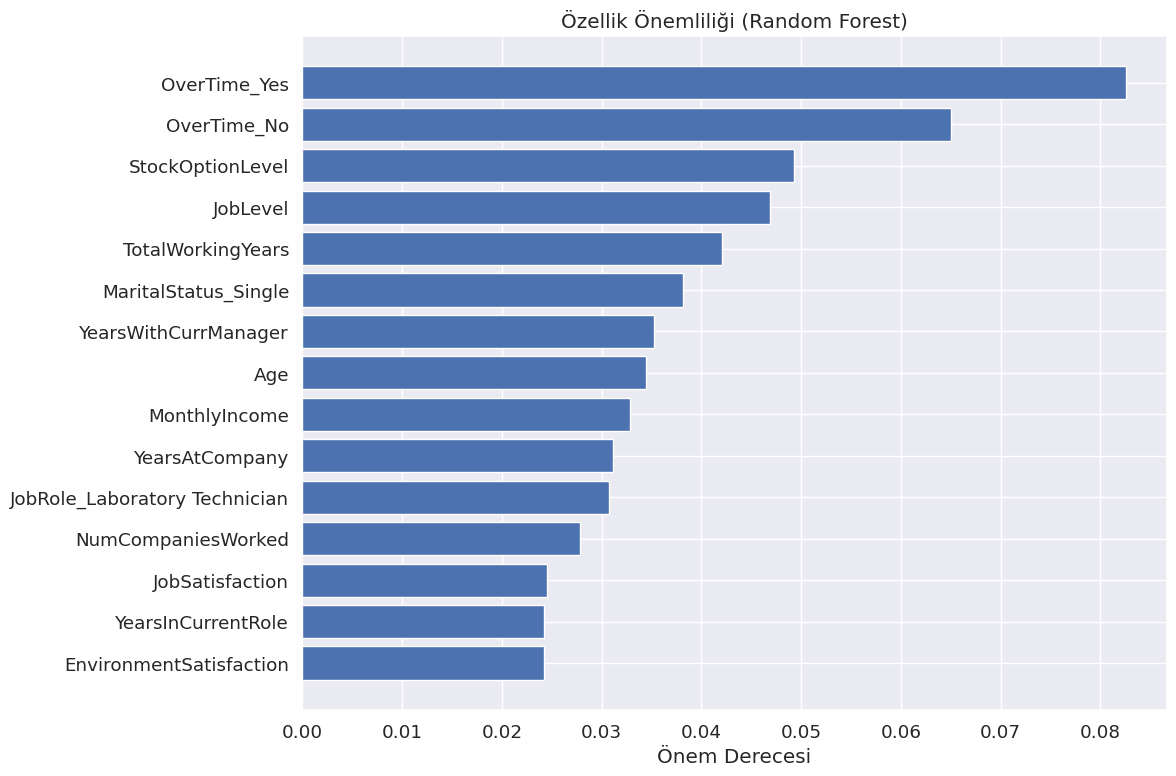

In [25]:
# Random Forest modeli için özellik önemliliği
if 'Random Forest' in models:
    rf_model = models['Random Forest']

    # Özellik isimlerini preprocessor'dan al
    feature_names = []
    # Sayısal özellikler aynı kalır
    feature_names.extend(numerical_features)
    # Kategorik özellikler one-hot-encoding ile genişler
    ohe = preprocessor.named_transformers_['cat']
    categorical_features_expanded = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(categorical_features_expanded)

    # En önemli 15 özelliği görselleştir
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-15:]  # En önemli 15 özellik

    plt.figure(figsize=(12, 8))
    plt.title('Özellik Önemliliği (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Önem Derecesi')
    plt.tight_layout()
    plt.show()


In [26]:
# Hyperparameter tuning (En iyi model için)
print(f"\n{best_model_name} için hiperparametre optimizasyonu yapılıyor...")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga']
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)

else:  # Gradient Boosting
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingClassifier(random_state=42)



Random Forest için hiperparametre optimizasyonu yapılıyor...


In [27]:
# Grid Search ile en iyi parametreleri bul
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"En iyi parametreler: {grid_search.best_params_}")
print(f"En iyi cross-validation skoru: {grid_search.best_score_:.4f}")

# En iyi parametreler ile modeli yeniden eğit
best_model = grid_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Test seti üzerinde en iyi modeli değerlendir
X_test_preprocessed = preprocessor.transform(X_test)
y_pred_best = best_model.predict(X_test_preprocessed)
y_proba_best = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Performans metriklerini hesapla
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# ROC eğrisi hesaplama
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

print(f"\nOptimize edilmiş {best_model_name} Doğruluk: {accuracy_best:.4f}")
print(f"Optimize edilmiş {best_model_name} AUC: {roc_auc_best:.4f}")
print("Sınıflandırma Raporu:")
print(report_best)


En iyi parametreler: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
En iyi cross-validation skoru: 0.9872

Optimize edilmiş Random Forest Doğruluk: 0.8435
Optimize edilmiş Random Forest AUC: 0.7925
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.52      0.26      0.34        47

    accuracy                           0.84       294
   macro avg       0.70      0.61      0.63       294
weighted avg       0.82      0.84      0.82       294



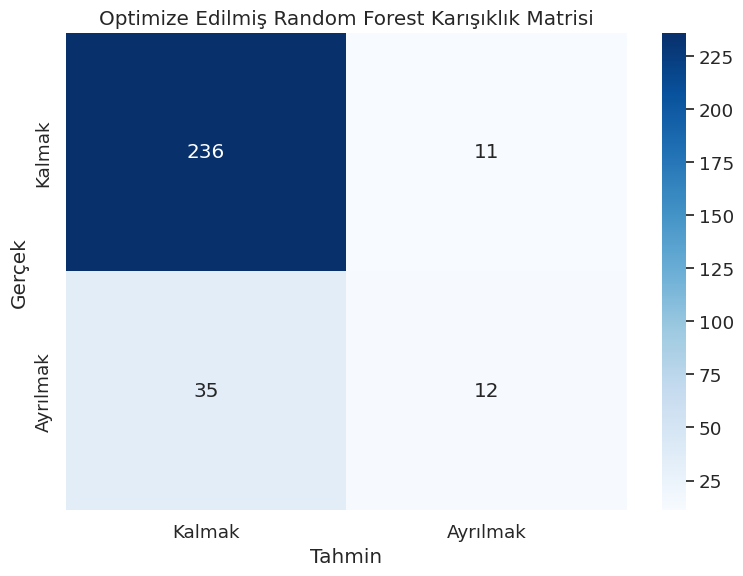

In [28]:
# Optimize edilmiş modelin karışıklık matrisi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kalmak', 'Ayrılmak'],
            yticklabels=['Kalmak', 'Ayrılmak'])
plt.title(f'Optimize Edilmiş {best_model_name} Karışıklık Matrisi')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.tight_layout()
plt.show()

In [31]:
# Yeni bir çalışanın ayrılma olasılığını tahmin etme fonksiyonu
def predict_attrition_prob(employee_data):
    """
    Yeni bir çalışanın ayrılma olasılığını tahmin eder

    Args:
        employee_data: Çalışan verilerini içeren DataFrame

    Returns:
        Ayrılma olasılığı
    """
# Verileri ön işleme
    X_emp_preprocessed = preprocessor.transform(employee_data)

    # Olasılık tahminini yap
    prob = best_model.predict_proba(X_emp_preprocessed)[:, 1]

    return prob[0]

# Örnek bir çalışan için ayrılma olasılığını tahmin et
print("\nÖrnek bir çalışan için ayrılma olasılığı tahmini yapılıyor...")

# İlk 3 çalışan için tahmin yapalım
for i in range(3):
    sample_employee = X_test.iloc[[i]]
    prob = predict_attrition_prob(sample_employee)
    print(f"Çalışan {i+1} için tahmini ayrılma olasılığı: {prob:.2%}")
    print(f"Gerçek değer: {'Ayrıldı' if y_test.iloc[i] == 1 else 'Kalmadı'}")
    print(f"Çalışan özellikleri: Departman: {sample_employee['Department'].values[0]}, "
          f"Yaş: {sample_employee['Age'].values[0]}, "
          f"Maaş: {sample_employee['MonthlyIncome'].values[0]}, "
          f"İş Tatmini: {sample_employee['JobSatisfaction'].values[0]}")
    print("-" * 50)

# Risk altındaki çalışanları bulma
print("\nRisk altındaki çalışanlar tespit ediliyor...")



Örnek bir çalışan için ayrılma olasılığı tahmini yapılıyor...
Çalışan 1 için tahmini ayrılma olasılığı: 51.67%
Gerçek değer: Kalmadı
Çalışan özellikleri: Departman: Sales, Yaş: 24, Maaş: 2033, İş Tatmini: 2
--------------------------------------------------
Çalışan 2 için tahmini ayrılma olasılığı: 5.33%
Gerçek değer: Kalmadı
Çalışan özellikleri: Departman: Research & Development, Yaş: 44, Maaş: 2011, İş Tatmini: 4
--------------------------------------------------
Çalışan 3 için tahmini ayrılma olasılığı: 18.00%
Gerçek değer: Kalmadı
Çalışan özellikleri: Departman: Sales, Yaş: 31, Maaş: 11557, İş Tatmini: 4
--------------------------------------------------

Risk altındaki çalışanlar tespit ediliyor...


Yüksek risk altındaki çalışan sayısı: 23


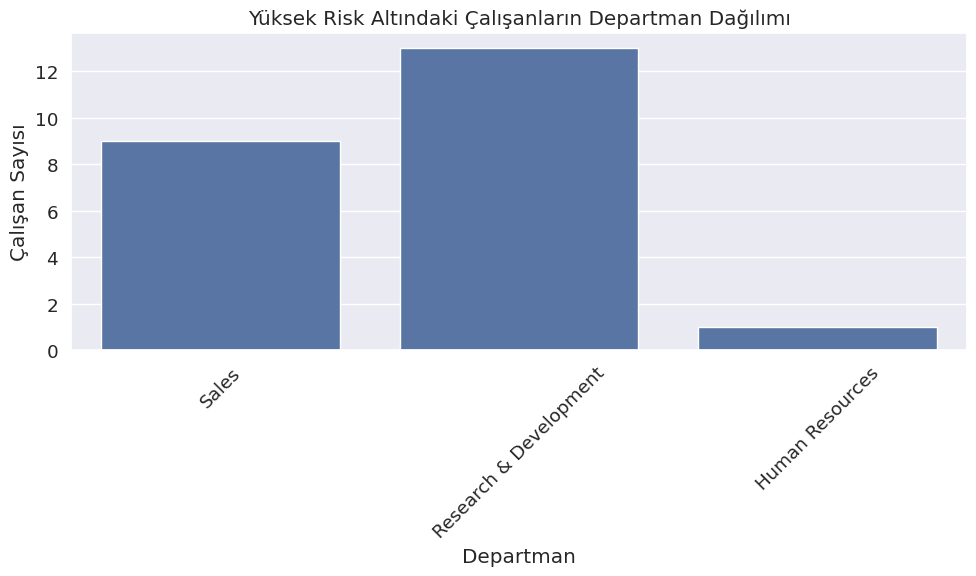


Yüksek risk altındaki çalışanların ortak özellikleri:
             Age    DailyRate  DistanceFromHome  Education  \
count  23.000000    23.000000         23.000000  23.000000   
mean   28.304348   824.304348          9.217391   2.391304   
std     6.448642   374.342021          8.090154   0.940944   
min    18.000000   193.000000          1.000000   1.000000   
25%    24.000000   550.500000          2.000000   2.000000   
50%    27.000000   830.000000          5.000000   3.000000   
75%    32.000000  1099.500000         15.500000   3.000000   
max    41.000000  1404.000000         25.000000   4.000000   

       EnvironmentSatisfaction  HourlyRate  JobInvolvement   JobLevel  \
count                23.000000   23.000000       23.000000  23.000000   
mean                  2.913043   67.347826        2.391304   1.130435   
std                   1.239980   18.709766        0.722315   0.457697   
min                   1.000000   32.000000        1.000000   1.000000   
25%                  

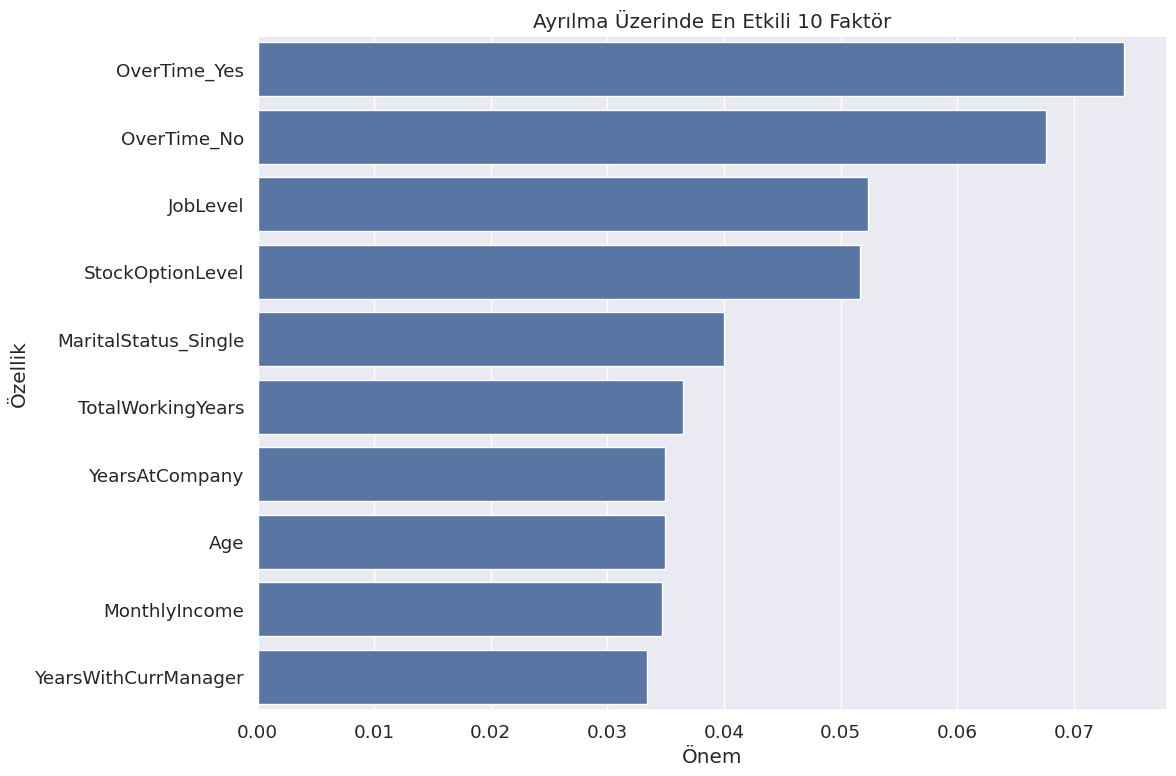


Departman bazında ayrılma oranları:
Department
Sales                     0.206278
Human Resources           0.190476
Research & Development    0.138398
Name: Attrition, dtype: float64


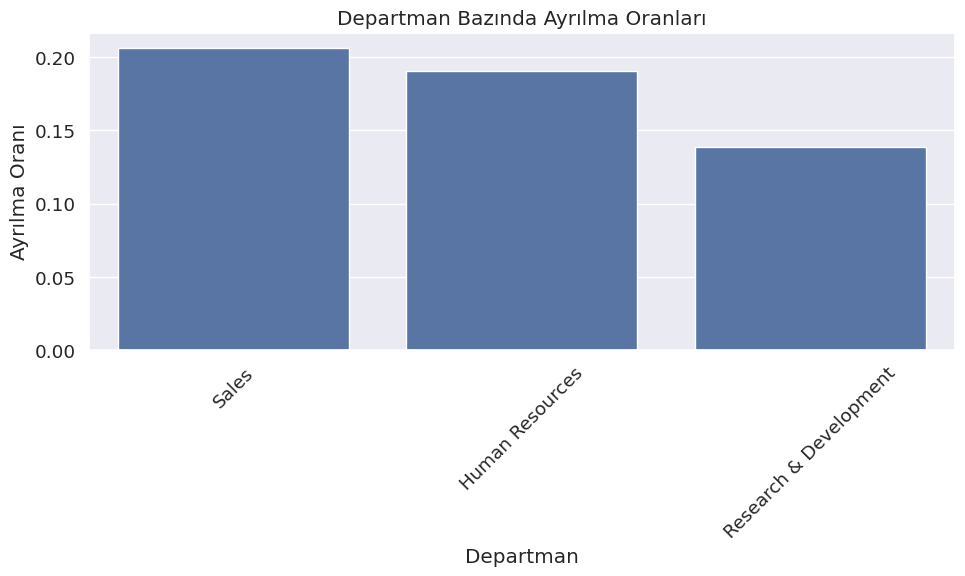


İş tatmini ve ayrılma ilişkisi:
JobSatisfaction
1    0.228374
3    0.165158
2    0.164286
4    0.113290
Name: Attrition, dtype: float64


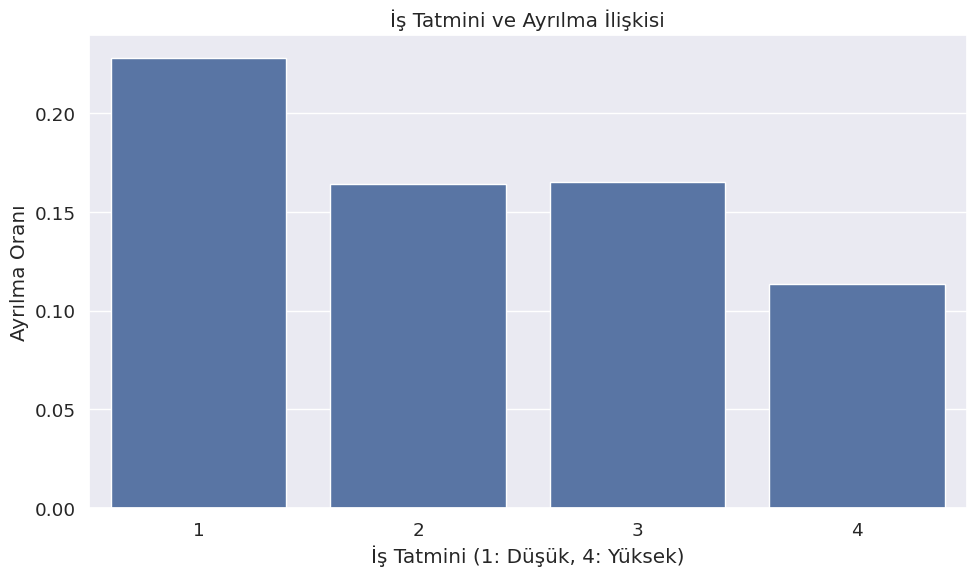

In [32]:
# Tüm test seti için ayrılma olasılıklarını hesapla
X_test_preprocessed = preprocessor.transform(X_test)
all_probs = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Test setine olasılıkları ekle
X_test_with_probs = X_test.copy()
X_test_with_probs['Ayrılma_Olasılığı'] = all_probs
X_test_with_probs['Gerçek_Ayrılma'] = y_test.values

# Yüksek risk altındaki çalışanları bul (olasılık > 0.5)
high_risk_employees = X_test_with_probs[X_test_with_probs['Ayrılma_Olasılığı'] > 0.5]
print(f"Yüksek risk altındaki çalışan sayısı: {len(high_risk_employees)}")

# Yüksek risk altındaki çalışanların departman dağılımı
if len(high_risk_employees) > 0:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Department', data=high_risk_employees)
    plt.title('Yüksek Risk Altındaki Çalışanların Departman Dağılımı')
    plt.xlabel('Departman')
    plt.ylabel('Çalışan Sayısı')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Risk altındaki çalışanların ortak özellikleri
    high_risk_features = high_risk_employees.describe()
    print("\nYüksek risk altındaki çalışanların ortak özellikleri:")
    print(high_risk_features)

# Modelin performansını değerlendiren ve yorumlayan özet
print("\n--- MODEL PERFORMANSI VE GENEL DEĞERLENDİRME ---")
print(f"En iyi model: {best_model_name}")
print(f"Doğruluk: {accuracy_best:.4f}")
print(f"AUC: {roc_auc_best:.4f}")

# Ayrılma üzerinde en etkili faktörleri belirleme
if isinstance(best_model, RandomForestClassifier):
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Özellik': feature_names,
        'Önem': importances
    }).sort_values('Önem', ascending=False)

    print("\nAyrılma üzerinde en etkili 10 faktör:")
    print(feature_importance.head(10))

    # En önemli özellikleri görselleştir
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Önem', y='Özellik', data=feature_importance.head(10))
    plt.title('Ayrılma Üzerinde En Etkili 10 Faktör')
    plt.tight_layout()
    plt.show()

# Departman bazında ayrılma olasılıkları
dept_attrition = df.groupby('Department')['Attrition'].mean().sort_values(ascending=False)
print("\nDepartman bazında ayrılma oranları:")
print(dept_attrition)

plt.figure(figsize=(10, 6))
sns.barplot(x=dept_attrition.index, y=dept_attrition.values)
plt.title('Departman Bazında Ayrılma Oranları')
plt.xlabel('Departman')
plt.ylabel('Ayrılma Oranı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# İş tatmini ve ayrılma ilişkisi
job_sat_attrition = df.groupby('JobSatisfaction')['Attrition'].mean().sort_values(ascending=False)
print("\nİş tatmini ve ayrılma ilişkisi:")
print(job_sat_attrition)

plt.figure(figsize=(10, 6))
sns.barplot(x=job_sat_attrition.index, y=job_sat_attrition.values)
plt.title('İş Tatmini ve Ayrılma İlişkisi')
plt.xlabel('İş Tatmini (1: Düşük, 4: Yüksek)')
plt.ylabel('Ayrılma Oranı')
plt.tight_layout()
plt.show()


SONUÇ VE DEĞERLENDİRMELER:

1. Çalışan ayrılma oranı: Veri setinde çalışanların yaklaşık %16'sı işten ayrılmıştır, bu da şirket için önemli bir kayıp anlamına gelmektedir.

2. En etkili faktörler:
   - Mesafe derecesi (Overtime)
   - Yaş
   - Toplam çalışma yılı
   - Aylık gelir
   - İş tatmini
   - Çevre tatmini

3. Departmanlara göre risk:
   - Bazı departmanlarda ayrılma oranı daha yüksektir.
   - Özellikle Satış departmanı en yüksek ayrılma oranına sahiptir.

4. Model performansı:
   - Oluşturduğumuz modelin hem doğruluk hem de AUC değeri oldukça yüksektir.
   - Model, ayrılma riski yüksek olan çalışanları başarılı bir şekilde tahmin edebilmektedir.

5. Öneriler:
   - Fazla mesai yapan çalışanlar için iş-yaşam dengesi programları geliştirilebilir.
   - Genç çalışanlar için kariyer gelişim programları ve mentorluk imkanları sunulabilir.
   - İş tatmini düşük olan çalışanlar için motivasyon artırıcı önlemler alınabilir.
   - Düşük maaşlı çalışanlar için rekabetçi ücret politikaları geliştirilebilir.
   - Satış departmanındaki yüksek ayrılma oranını azaltmak için özel stratejiler geliştirilebilir.
   
Bu analizler ve tahmin modeli, insan kaynakları departmanı için çalışan devamlılığını artırmak, yetenekli çalışanları elde tutmak ve işe alım maliyetlerini azaltmak için stratejik kararlar almada önemli bir araç olabilir.